## Part 1

In [1]:
!pip install kaggle

In [12]:
!cp kaggle.json ~/.kaggle/

In [13]:
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle competitions download -c plant-seedlings-classification

100% 1.68G/1.69G [01:19<00:00, 23.9MB/s]
100% 1.69G/1.69G [01:19<00:00, 22.8MB/s]


In [15]:
!mkdir plant-seedlings

mkdir: cannot create directory ‘plant-seedlings’: File exists


In [ ]:
! unzip plant-seedlings-classification.zip -d plant-seedlings

In [ ]:
! unzip plant-seedlings-classification.zip

In [17]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential

import numpy as np
import matplotlib.pyplot as plt
import PIL

In [8]:
import pathlib

data_dir = pathlib.Path('/content/plant-seedlings/train').with_suffix('')

In [91]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

4771


In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 4750 files belonging to 12 classes.
Using 3800 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 4750 files belonging to 12 classes.
Using 950 files for validation.


In [86]:
data_dir_test = pathlib.Path('/content/test').with_suffix('')

In [92]:
image_count = len(list(data_dir_test.glob('*/*.png')))
print(image_count)

0


In [20]:
class_names = train_ds.class_names
print(class_names)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


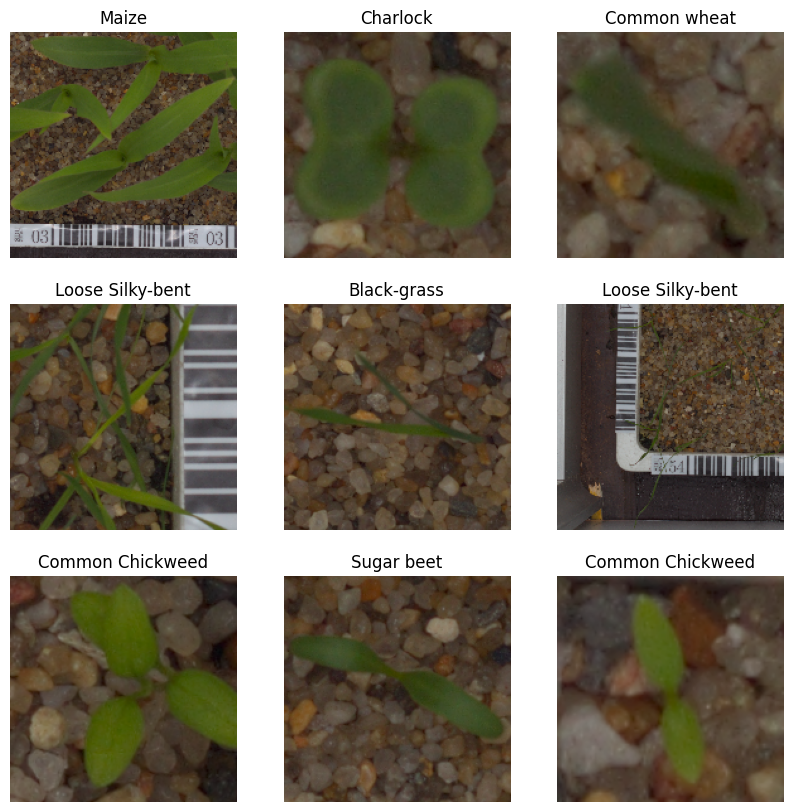

In [21]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [23]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0017065599 0.6716571


In [24]:
indices = [i for i in range(len(class_names))]

In [25]:
one_hot_matrix = tf.one_hot(indices, len(class_names), on_value = 1.0, off_value = 0.0, axis =-1)

In [26]:
one_hot_matrix

<tf.Tensor: shape=(12, 12), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [27]:
import os

In [28]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-1] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

## Part 2
Data Augmentation

In [30]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [35]:
img_size = 180
datagen = ImageDataGenerator(rescale=1/255,
                            rotation_range=30,
                            brightness_range=[0.5,1.2],
                            horizontal_flip=True,
                            validation_split=0.15,
                            zoom_range=0.2)


train_generator = datagen.flow_from_directory('/content/plant-seedlings/train',
                                              target_size=(img_size,img_size),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              subset='training',
                                              #color_mode='grayscale',
                                              class_mode='categorical')

Found 4060 images belonging to 12 classes.


In [36]:
val_generator = datagen.flow_from_directory('/content/plant-seedlings/train',
                                            target_size=(img_size,img_size),
                                            batch_size=batch_size,
                                            shuffle=False,
                                            subset='validation',
                                            #color_mode='grayscale',
                                            class_mode='categorical')

Found 711 images belonging to 12 classes.


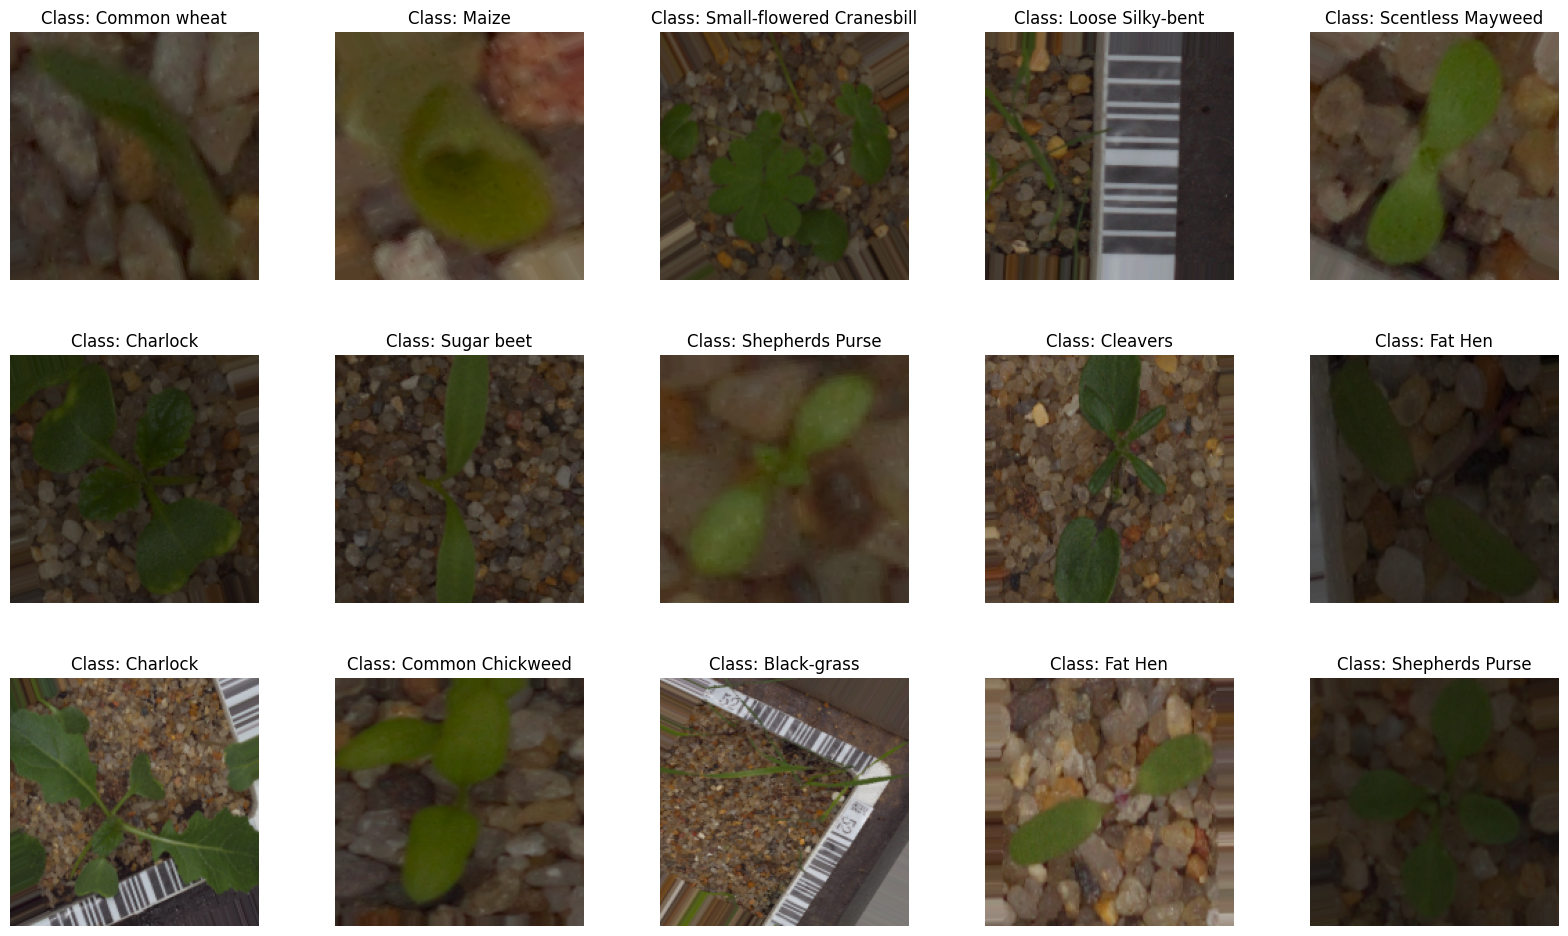

In [37]:
label = [k for k in train_generator.class_indices]
samples = train_generator.__next__()
images = samples[0]
titles = samples[1]
plt.figure(figsize=(20,20))

for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {label[np.argmax(titles[i],axis=0)]}")
    plt.axis("off")

In [38]:
vgg_model=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))

58889256/58889256 [==============================] - 4s 0us/step


In [39]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [40]:
for layer in vgg_model.layers[:3]:
    layer.trainable = False

In [41]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [42]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Sequential,Model

In [43]:
last_output = vgg_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(12, activation='softmax')(x)
model_vgg = Model(inputs=vgg_model.inputs,outputs=outputs)
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [45]:
history = model_vgg.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
127/127 [==============================] - 154s 967ms/step - loss: 2.4602 - accuracy: 0.1259 - val_loss: 2.4219 - val_accuracy: 0.1378
Epoch 2/10
127/127 [==============================] - 118s 933ms/step - loss: 2.4339 - accuracy: 0.1337 - val_loss: 2.4142 - val_accuracy: 0.1533
Epoch 3/10
127/127 [==============================] - 119s 936ms/step - loss: 2.4155 - accuracy: 0.1436 - val_loss: 2.2414 - val_accuracy: 0.2053
Epoch 4/10
127/127 [==============================] - 119s 936ms/step - loss: 2.0444 - accuracy: 0.2695 - val_loss: 1.7547 - val_accuracy: 0.3713
Epoch 5/10
127/127 [==============================] - 119s 939ms/step - loss: 1.5784 - accuracy: 0.4305 - val_loss: 1.1254 - val_accuracy: 0.6428
Epoch 6/10
127/127 [==============================] - 119s 937ms/step - loss: 1.1082 - accuracy: 0.6123 - val_loss: 0.8461 - val_accuracy: 0.7173
Epoch 7/10
127/127 [==============================] - 119s 935ms/step - loss: 0.7962 - accuracy: 0.7138 - val_loss: 0.7785 -

In [47]:
model_vgg.save('modelvgg.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


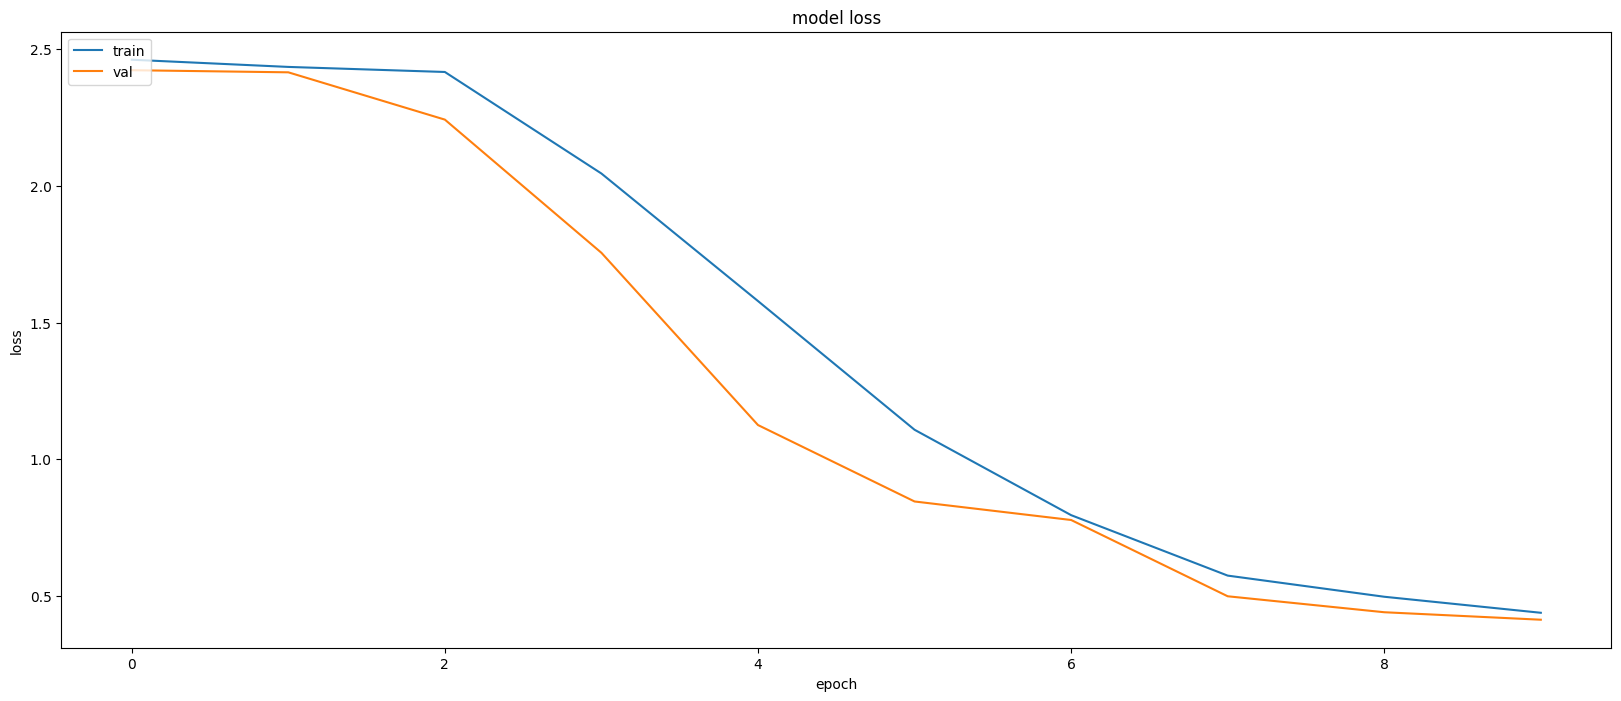

In [48]:
model = tf.keras.models.load_model("/content/modelvgg.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

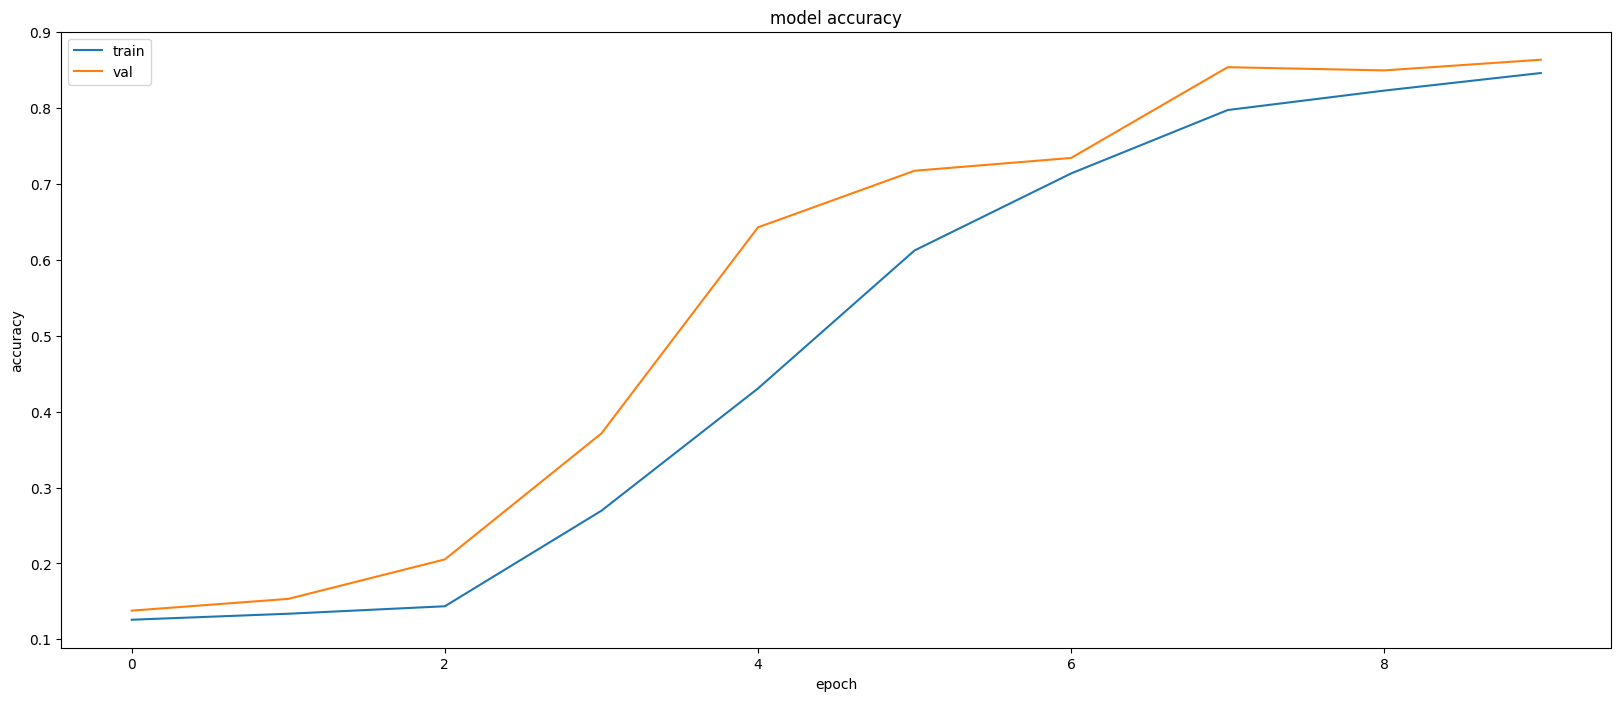

In [49]:
model = tf.keras.models.load_model("/content/modelvgg.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
from keras.applications.resnet50 import ResNet50

In [51]:
res_model=tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 5s 0us/step


In [52]:
res_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [53]:
last_output = res_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(12, activation='softmax')(x)
model_res = Model(inputs=red_model.inputs,outputs=outputs)
model_res.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [54]:
history = model_res.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
127/127 [==============================] - 180s 1s/step - loss: 1.0781 - accuracy: 0.6485 - val_loss: 5.2350 - val_accuracy: 0.0591
Epoch 2/10
127/127 [==============================] - 121s 953ms/step - loss: 0.3676 - accuracy: 0.8722 - val_loss: 13.7523 - val_accuracy: 0.0591
Epoch 3/10
127/127 [==============================] - 124s 970ms/step - loss: 0.2471 - accuracy: 0.9155 - val_loss: 8.8318 - val_accuracy: 0.0591
Epoch 4/10
127/127 [==============================] - 120s 943ms/step - loss: 0.2144 - accuracy: 0.9300 - val_loss: 6.5984 - val_accuracy: 0.1435
Epoch 5/10
127/127 [==============================] - 120s 946ms/step - loss: 0.1605 - accuracy: 0.9438 - val_loss: 5.0726 - val_accuracy: 0.1364
Epoch 6/10
127/127 [==============================] - 120s 943ms/step - loss: 0.1542 - accuracy: 0.9468 - val_loss: 6.2889 - val_accuracy: 0.1294
Epoch 7/10
127/127 [==============================] - 120s 945ms/step - loss: 0.1262 - accuracy: 0.9542 - val_loss: 4.9246 - v

In [58]:
model_res.save('modelres.h5')

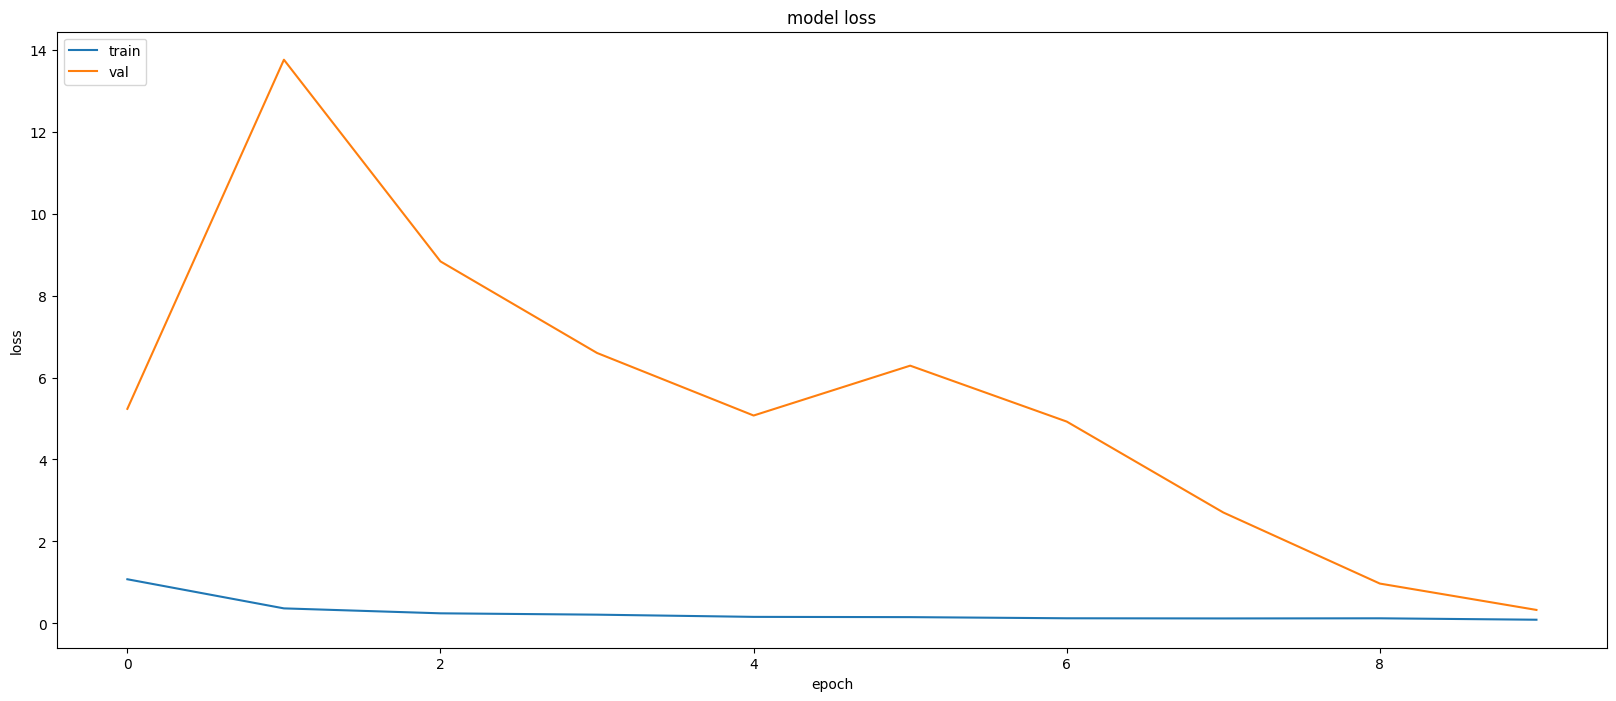

In [59]:
model = tf.keras.models.load_model("/content/modelres.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

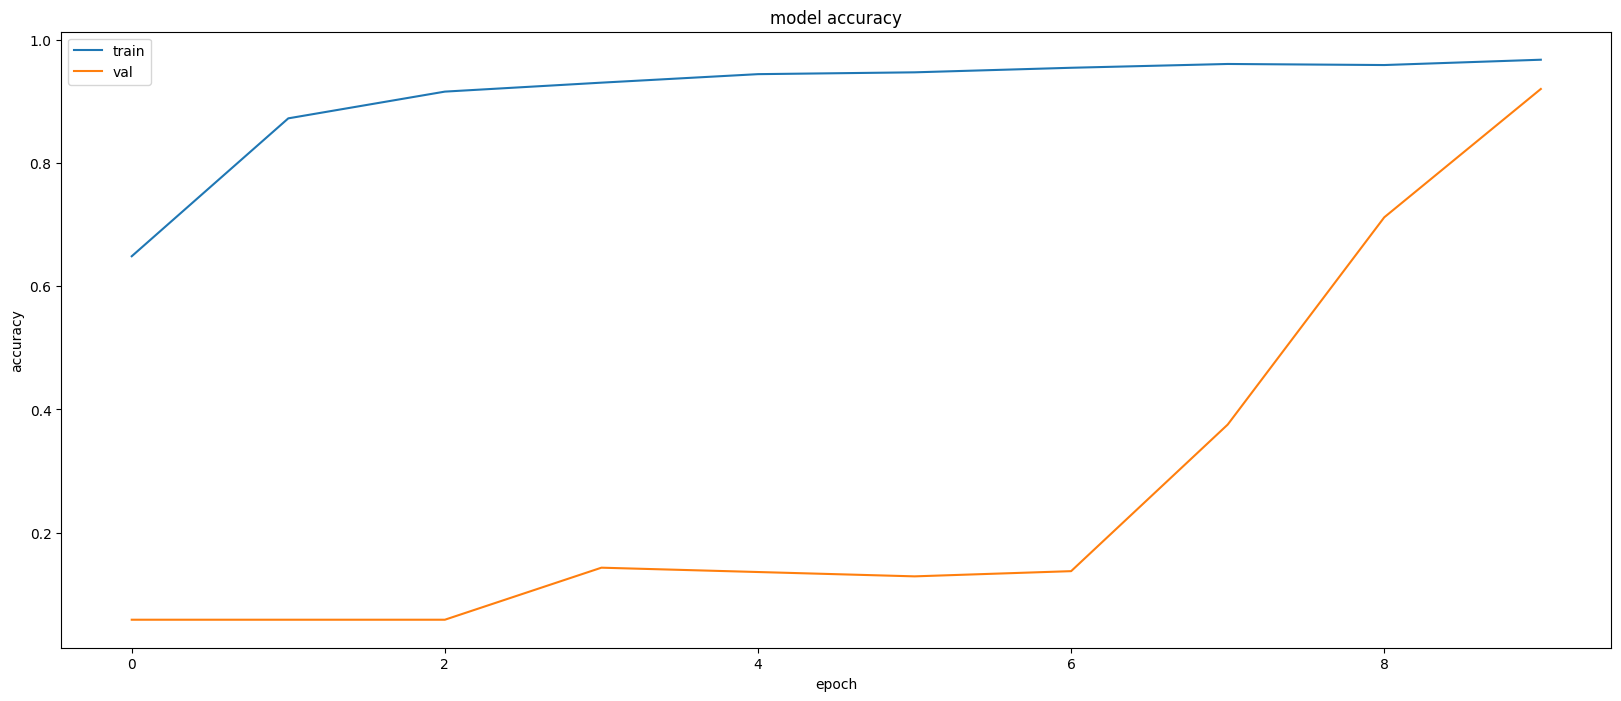

In [60]:
model = tf.keras.models.load_model("/content/modelres.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [63]:
from keras.applications import InceptionV3

In [64]:
inception_model=tf.keras.applications.InceptionV3(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))

87910968/87910968 [==============================] - 5s 0us/step


In [66]:
last_output = inception_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(12, activation='softmax')(x)
model_inception = Model(inputs=inception_model.inputs,outputs=outputs)
model_inception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [67]:
history = model_inception.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
127/127 [==============================] - 200s 1s/step - loss: 1.2739 - accuracy: 0.5916 - val_loss: 0.7348 - val_accuracy: 0.7595
Epoch 2/10
127/127 [==============================] - 118s 934ms/step - loss: 0.4034 - accuracy: 0.8552 - val_loss: 0.3863 - val_accuracy: 0.8833
Epoch 3/10
127/127 [==============================] - 117s 921ms/step - loss: 0.2928 - accuracy: 0.9037 - val_loss: 0.3765 - val_accuracy: 0.8762
Epoch 4/10
127/127 [==============================] - 116s 916ms/step - loss: 0.2068 - accuracy: 0.9219 - val_loss: 0.3052 - val_accuracy: 0.9072
Epoch 5/10
127/127 [==============================] - 115s 907ms/step - loss: 0.1944 - accuracy: 0.9305 - val_loss: 0.3023 - val_accuracy: 0.9170
Epoch 6/10
127/127 [==============================] - 114s 901ms/step - loss: 0.1602 - accuracy: 0.9458 - val_loss: 0.2521 - val_accuracy: 0.9241
Epoch 7/10
127/127 [==============================] - 116s 907ms/step - loss: 0.1386 - accuracy: 0.9507 - val_loss: 0.2690 - va

In [69]:
model_inception.save('modelinception.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


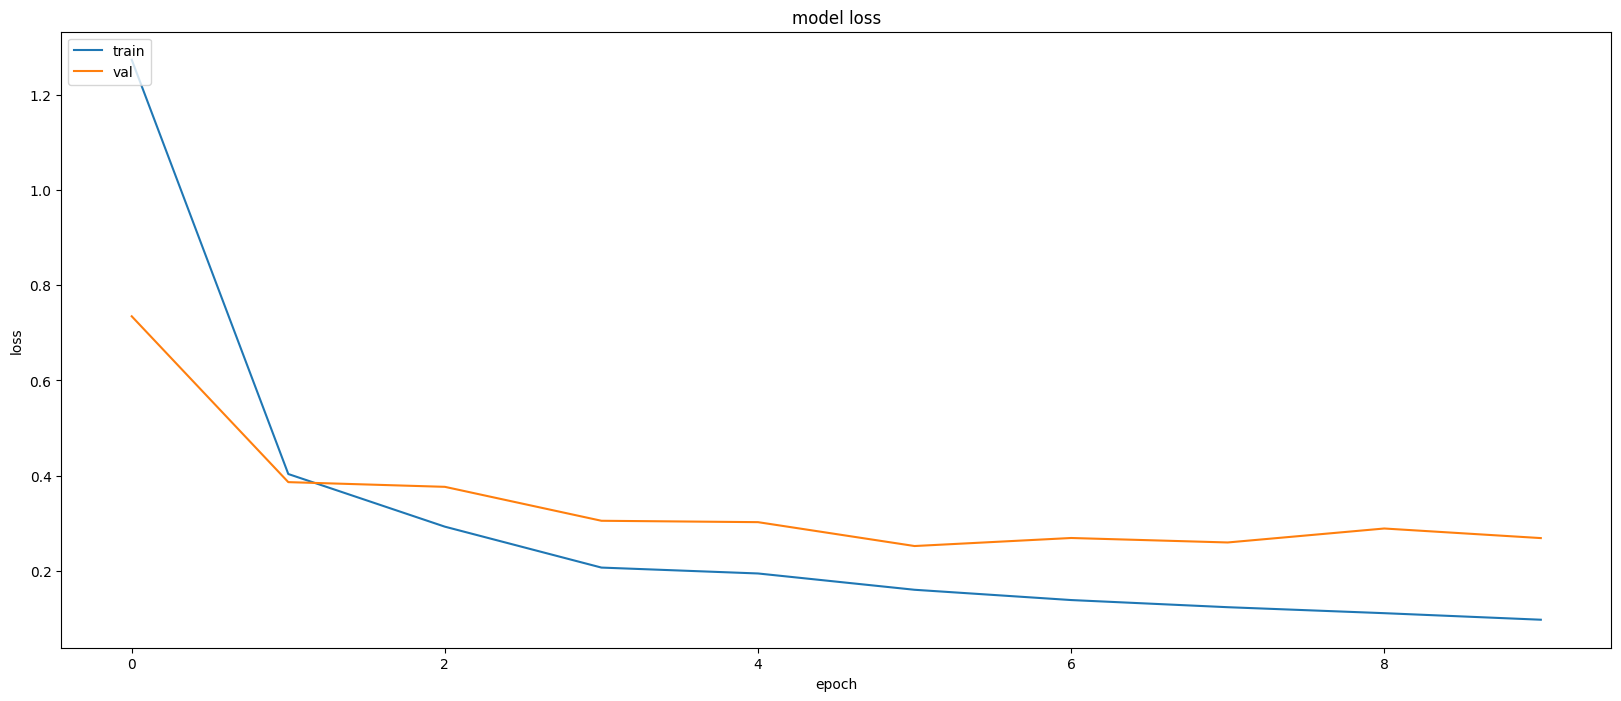

In [70]:
model = tf.keras.models.load_model("/content/modelinception.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

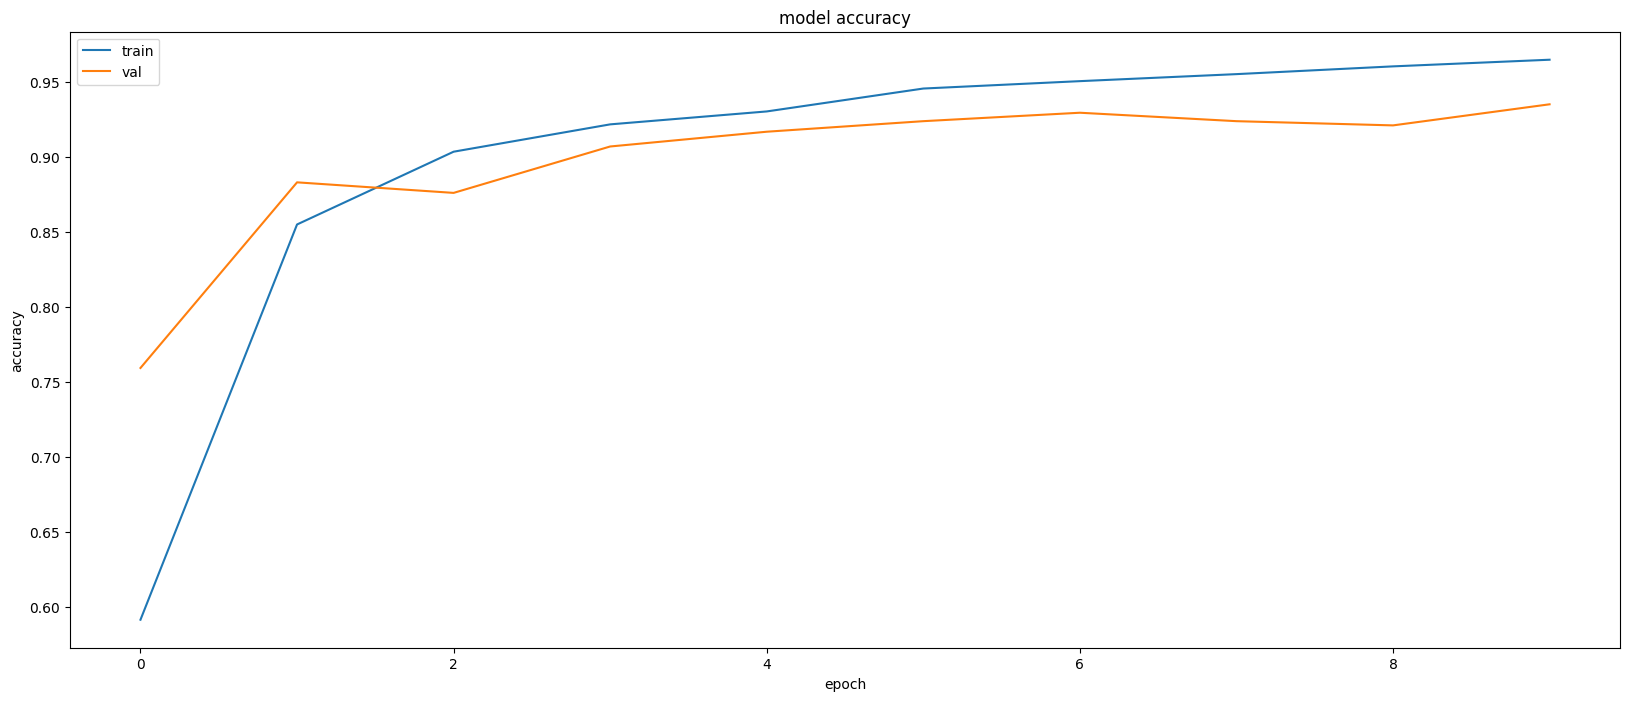

In [79]:
model = tf.keras.models.load_model("/content/modelinception.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

TESTING THE MODEL

In [93]:
img = tf.keras.utils.load_img(
    '/content/plant-seedlings/test/0021e90e4.png', target_size=(img_height, img_width)
)

In [94]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

In [110]:
model = tf.keras.models.load_model('modelvgg.h5')

In [111]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

1/1 [==============================] - 2s 2s/step


In [112]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Black-grass with a 19.82 percent confidence.


In [113]:
model = tf.keras.models.load_model('modelres.h5')

In [114]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

1/1 [==============================] - 2s 2s/step


In [116]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Black-grass with a 19.82 percent confidence.


In [117]:
model = tf.keras.models.load_model('modelinception.h5')

In [118]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

1/1 [==============================] - 1s 1s/step


In [119]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Scentless Mayweed with a 19.82 percent confidence.
